## Implementation of Pointer Network for Convex hull

Based on the following paper: <i>Pointer Networks</i>. Implemented for the task of convex hull; using teacher-forcing during training. Using the same data that was presented alongside the paper.

In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,Input,RepeatVector,Activation,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.compat.v1.enable_eager_execution()

### Data Processing

Using the same data from the paper - in which the output is ordered based on the ordering of the input (ordering of the output labels was found to be very important for model performance).

In [3]:
def load_data(data_dir="../data/convex_hull/",file_no=5,num_data_points=2000):
    """ loads convex hull data
    args:
        file_no: unique indicator for the type of convex hull dataset to pull from
        num_data_points: number of datapoints to pull from file
    """
    fname = "convex_hull_{}_test.txt".format(file_no)
    num_points = file_no*2
    
    all_data_points = []
    all_delayed_y = []
    all_labels = []
    with open(data_dir+fname) as data_file:
        lines = data_file.readlines()
        for i in range(num_data_points):
            line = lines[i].strip().split()
            data_points = [[float(line[i]),float(line[i+1])] for i in range(0,num_points,2)]
            labels = [int(line[i])-1 for i in range(num_points+1,len(line))]
            delayed_y = [[0.0,0.0]] # prepend with 2x1 zero vector
            delayed_y += [data_points[i] for i in labels[:-1]] # don't include the last prediction as a delayed_input
            delayed_y += [[0.0,0.0] for i in range(file_no+1-len(labels))] # padding with 2x1 zero-vectors
            labels = labels+[-1 for i in range(file_no+1-len(labels))] # appending -1 to symbolize padding
            all_delayed_y.append(delayed_y)
            all_data_points.append(data_points)
            all_labels.append(labels)
    return np.array(all_data_points).astype("float32"),np.array(all_labels).astype("int32"),np.array(all_delayed_y).astype("float32")

In [4]:
x_5,y_5,delayed_y_5 = load_data(file_no=5,num_data_points=2000)
x_10,y_10,delayed_y_10 = load_data(file_no=10,num_data_points=2000)
print(x_5.shape,y_5.shape,delayed_y_5.shape,x_10.shape,y_10.shape,delayed_y_10.shape)
print(y_10[0])

(2000, 5, 2) (2000, 6) (2000, 6, 2) (2000, 10, 2) (2000, 11) (2000, 11, 2)
[ 0  9  7  3  6  8  1  0 -1 -1 -1]


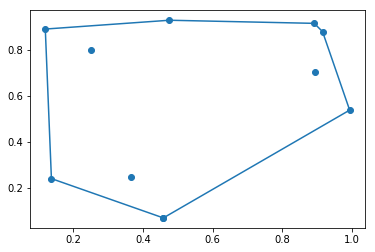

In [5]:
ex = x_10[0]
ey = y_10[0]
p_ex = np.array([ex[i] for i in ey if i != -1]) # ordering for the lines
p_no_ex = np.array([ex[i] for i in range(0,10) if i not in ey]) # remaining points no in border
plt.plot(p_ex[:,0],p_ex[:,1],'-o')
plt.scatter(p_no_ex[:,0],p_no_ex[:,1])
plt.show()

In [6]:
# given the labels output for the cross-entropy is different lengths, need to mask out labels padding
y_5_bool = y_5 != -1
y_5_bool = y_5_bool.astype("int32")
y_10_bool = y_10 != -1
y_10_bool = y_10_bool.astype("int32")
print(y_5[0])
print(y_5_bool[0])
y_5[y_5==-1]=0 # changing the padding to be the 0-th index, which is required by tensorflow cross-entropy loss
y_10[y_10==-1]=0
print(y_5[0])

[ 0  1  2  4  0 -1]
[1 1 1 1 1 0]
[0 1 2 4 0 0]


### Modeling

Note: it would probably help to have the model switch away from teacher-forcing after some period of epochs (e.g. using argmax of the attention dist. to get the next input from x)

In [7]:
def pointer_network(input_len=10):
    """ Wrapper for the pointer network
    """
    decoder_lstm = LSTM(64,activation="tanh",return_state=True)
    w1 = Dense(64,use_bias=False,activation=None)
    w2 = Dense(64,use_bias=False,activation=None)
    v = Dense(1,use_bias=False,activation=None)
    out = pointer_network_forward(decoder_lstm,w1,w2,v,input_len)
    return out

In [8]:
def pointer_network_forward(decoder_lstm,w1,w2,v,input_len):
    """ Different from the original model in that the decoder is detached from the encoder
        Input to the decoder portion is just the prediction from the previous time-step
    """
    x = Input(shape=(None,2))
    delayed_y = Input(shape=(input_len+1,2)) # if you reload weights, shape of this Input can be changed
    s0 = Input(shape=(64)) # initial state
    c0 = Input(shape=(64))
    s=s0
    c=c0
    a = Bidirectional(LSTM(32,activation="tanh",return_sequences=True),merge_mode="concat")(x) # encoding
    
    outputs = []
    for i in range(input_len+1):
        decoder_step_input = tf.expand_dims(delayed_y[:,i,:],axis=1)
        s,_,c = decoder_lstm(decoder_step_input,initial_state=[s,c]) # s:decoder hidden state, shape:(batch_size,64)
        s_rep = RepeatVector(input_len)(s)
        u = v(Activation("tanh")(w1(a)+w2(s_rep)))
        u = tf.squeeze(u,axis=-1) # logits
        ## a = Activation("softmax")(u) # scaled attention
        outputs.append(u) # prediction is simply the attention distribution over the input
        
    outputs = K.permute_dimensions(tf.convert_to_tensor(outputs),(1,0,2))
    
    model = Model(inputs=[x,delayed_y,s0,c0],outputs=outputs)
    return model

In [9]:
def loss_function(labels,logits,mask):
    """ Categorical cross-entropy
    """
    #sparse_categorical_crossentropy(y_true=labels,y_pred=logits,from_logits=False)
    #tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits)
    return tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits,weights=mask)

In [10]:
model = pointer_network(5) # initially starting with len=5 data
x = x_5
y = y_5
y_mask = y_5_bool
delayed_y = delayed_y_5

optimizer=Adam(lr=0.003)

In [12]:
model.load_weights("model.h5")

In [14]:
## training the model, switching between the two datasets of different length
num_epochs = 20
s0 = np.zeros((25,64)).astype("float32")
c0 = np.zeros((25,64)).astype("float32")

for epoch_i in range(num_epochs):
    losses = []
    
    if epoch_i!=0 and epoch_i%2 == 0: # selecting specific model and data to use for the epoch
        model = pointer_network(5)
        model.load_weights("model.h5")
        x = x_5
        y = y_5
        y_mask = y_5_bool
        delayed_y = delayed_y_5
    elif epoch_i%2 != 0:
        model = pointer_network(10)
        model.load_weights("model.h5")
        x = x_10
        y = y_10
        y_mask = y_10_bool
        delayed_y = delayed_y_10
        
    for i in range(0,len(x_5)-25,25): # batch size of 25
        x_subset = x[i:i+25]
        y_subset = y[i:i+25]
        y_mask_subset = y_mask[i:i+25]
        y_delayed = delayed_y[i:i+25]
        
        with tf.GradientTape() as tape:
            prediction_logits = model([x_subset,y_delayed,s0,c0])
            loss = loss_function(y_subset,prediction_logits,y_mask_subset)
                
        losses.append(float(loss))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    model.save_weights("model.h5") # save weights on each epoch
    print(sum(losses)/len(losses))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.3247627253773846
0.4333499783202063
0.2325992500291595
0.4396351092978369
0.21368956848790374
0.43655793651749814
0.20518176531112647
0.42873773959618583
0.19912522738870186
0.42174302249015133
0.1938000082781043
0.41353416178799884
0.18881990241853497
0.4054622314398802
0.1842686017102833
0.39773321830773656
0.1811467634537552
0.3898669832114932
0.17725347378585912
0.38199295197861105


### Test Time Predictions

In [7]:
def pointer_network_testtime(input_len=10):
    """ Wrapper for the test-time pointer network
    """
    decoder_lstm = LSTM(64,activation="tanh",return_state=True)
    w1 = Dense(64,use_bias=False,activation=None)
    w2 = Dense(64,use_bias=False,activation=None)
    v = Dense(1,use_bias=False,activation=None)
    out = pointer_network_forward_testtime(decoder_lstm,w1,w2,v,input_len)
    return out

In [8]:
def pointer_network_forward_testtime(decoder_lstm,w1,w2,v,input_len):
    """ There is no longer a delayed_input (teacher-forcing) and so the model will go one step at a time
        Ineffective implementation because the encoding B-RNN is run multiple times
    """
    x = Input(shape=(None,2))
    delayed_y = Input(shape=(2)) # current input to the decoder LSTM (output from prev time-step)
    s_curr = Input(shape=(64)) # current descoder-lstm state
    c_curr = Input(shape=(64))
    s=s_curr
    c=c_curr
    a = Bidirectional(LSTM(32,activation="tanh",return_sequences=True),merge_mode="concat")(x) # encoding
    
    # single step through the decoder
    decoder_step_input = tf.expand_dims(delayed_y,axis=1)
    s,_,c = decoder_lstm(decoder_step_input,initial_state=[s,c]) # outputs new s,c states
    s_rep = RepeatVector(input_len)(s)
    u = v(Activation("tanh")(w1(a)+w2(s_rep)))
    u = tf.squeeze(u,axis=-1) # logits
    a = Activation("softmax")(u) # scaled attention
    
    model = Model(inputs=[x,delayed_y,s_curr,c_curr],outputs=[a,s,c])
    return model

In [9]:
model = pointer_network_testtime(input_len=1)
model.load_weights("model.h5")

In [10]:
i=1
s0 = np.zeros((1,64)).astype("float32") # initializing the parameters/data
c0 = np.zeros((1,64)).astype("float32")
delayed_y = np.zeros((1,2)).astype("float32")
x = np.expand_dims(x_5[i],axis=0)
y = y_5[i]

In [11]:
all_predictions = []
a,s,c = model([x,delayed_y,s0,c0]) # getting the first prediction
first_pred = np.argmax(a)
delayed_y = np.expand_dims(x[0][first_pred],axis=0) # updated to be the output prediction from the first step
all_predictions.append(first_pred)

In [12]:
pred=-1
# looping to get the remaining predictions
while pred != first_pred: # sequence is complete when the first index (prediction) is predicted again
    a,s,c = model([x,delayed_y,s.numpy(),c.numpy()]) # getting the first prediction
    pred = np.argmax(a)
    delayed_y = np.expand_dims(x[0][pred],axis=0)
    all_predictions.append(pred)

In [13]:
print(y)
print(all_predictions)

[0 1 4 3 2 0]
[0, 1, 4, 3, 2, 0]
